# Segmentez des clients d'un site e-commerce - *Notebook exploration*

## Mission

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. 

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiqr.

 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.

## Analyse exploratoire

### 1 - Découverte du jeu de données

Les données sont issues de la base de données d'Olist, obtenues via un script sql (voir script en pièce jointe).

In [5]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import timeit

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


In [7]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_5/data_projet/source/data_olist.csv", sep=',', low_memory=False)
data.head()

,customer_id,latitude,longitude,days_since_first_order,recence,frequence,montant
0,00012a2ce6f8dcda20d059ce98491703,-23.491469,-46.762668,337,337,2591.749387,89.80
1,000161a058600d5901f007fab4c27140,-20.341986,-45.107222,458,458,2713.018762,54.90
2,0001fd6190edaaf884bcaf3d49edf079,-18.494666,-40.385265,596,596,2850.958912,179.99
3,0002414f95344307404f0ace7a26f1d5,-21.770599,-43.355230,427,427,2681.873762,149.90
4,000379cdec625522490c315e70c7a9fb,-23.735298,-46.686224,198,198,2452.850880,93.00


In [14]:
data.shape

(96214, 7)

In [16]:
data.describe()

,latitude,longitude,days_since_first_order,recence,frequence,montant
count,96214.000000,96214.000000,96214.000000,96214.000000,96214.000000,96214.000000
mean,-21.140182,-46.132311,288.319299,288.319299,2403.541217,137.045198
std,5.705148,4.095903,152.860241,152.860241,451.418987,209.096850
min,-33.683447,-72.456263,49.000000,49.000000,124.588780,0.850000
25%,-23.578930,-48.062302,164.000000,164.000000,2380.629407,45.900000
50%,-22.898404,-46.615229,269.000000,269.000000,2499.973420,86.700000
75%,-20.047075,-43.503871,398.000000,398.000000,2633.882216,149.900000
max,43.684961,13.820214,762.000000,762.000000,2999.015775,13440.000000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96214 entries, 0 to 96213
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             96214 non-null  object 
 1   latitude                96214 non-null  float64
 2   longitude               96214 non-null  float64
 3   days_since_first_order  96214 non-null  int64  
 4   recence                 96214 non-null  int64  
 5   frequence               96214 non-null  float64
 6   montant                 96214 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 5.1+ MB


In [21]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


customer_id               0.0
latitude                  0.0
longitude                 0.0
days_since_first_order    0.0
recence                   0.0
frequence                 0.0
montant                   0.0
dtype: float64

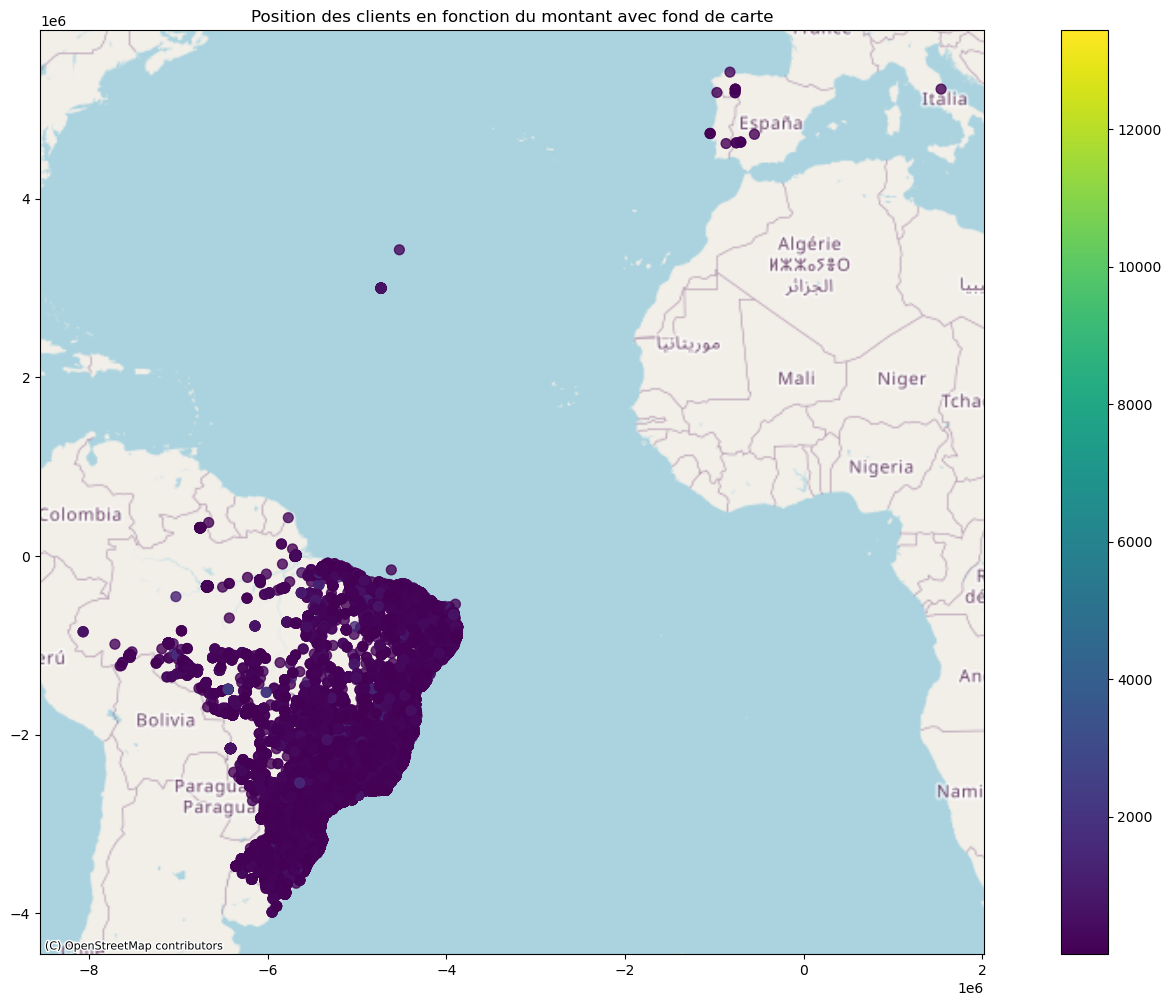

In [11]:
# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs="EPSG:4326"
)

# Reprojeter en Web Mercator (nécessaire pour les fonds de carte)
gdf = gdf.to_crs(epsg=3857)

# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(20, 12),
    alpha=0.8,
    markersize=50                    # Taille des points
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap
plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()